In [18]:
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew
import numpy as np

data = open("Number_23.txt")

numbers = data.read().split()

for i in range(len(numbers)):
    num = numbers[i].split('e')
    numbers[i] = float(num[0])*10**int(num[1])
    
data.close()
    
numbers = np.array(numbers)
numbers.sort()
print(numbers)

[ 0.04299163  0.04390213  0.14511736  0.16615495  0.17362415  0.20404162
  0.29260652  0.32142829  0.35323518  0.37849315  0.4162037   0.48787697
  0.50401063  0.527445    0.59059446  0.61388191  0.66075068  0.69704734
  0.74246764  0.74249747  0.79248831  0.79487285  0.80870308  0.81725431
  0.89879999  0.96755855  0.97508832  0.98461687  1.0550455   1.0795209
  1.0850069   1.126669    1.168739    1.2043996   1.3149467   1.3166846
  1.459579    1.6400076   1.7470823   1.8039731   1.9094547   2.1174543
  2.123387    2.1341648   2.2055114   2.209057    2.2247551   2.2534512
  2.6909818   2.7771968   3.2369354   3.2926501   3.3252833   3.3307154
  3.4603586   4.3261417   4.5082169   6.6633089   7.9855767  13.232469  ]


In [19]:
print(f"Mean: {round(np.mean(numbers), 3)}")
# unbiased = несмещенные
print(f"Variance(unbiased): {round(np.var(numbers, ddof=1), 3)}")
print(f"Skew(unbiased): {round(skew(numbers, bias=False), 3)}") # Коэффициент ассиметрии
print(f"Kurtosis(unbiased): {round(kurtosis(numbers, bias=False), 3)}") # Коэффициент эксцесса (можно вычесть 3, тогда для нормального == 0)

Mean: 1.786
Variance(unbiased): 4.593
Skew(unbiased): 3.289
Kurtosis(unbiased): 14.126


[0.0, 1.4166666666666667, 2.8333333333333335, 4.25, 5.666666666666667, 7.083333333333334, 8.5, 13.232469]


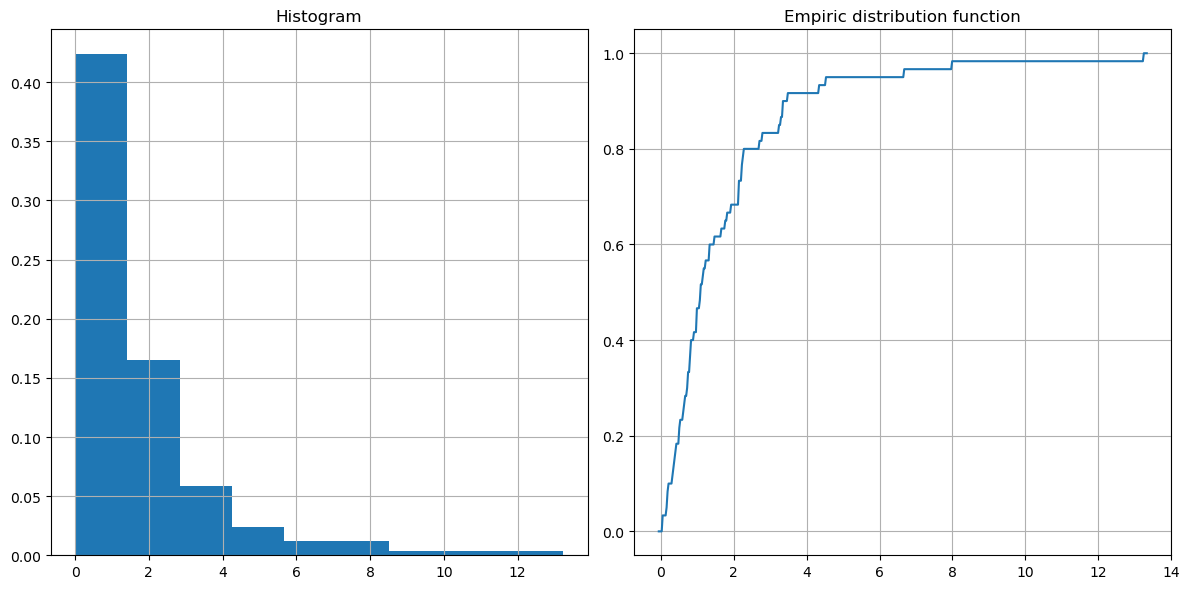

In [20]:
def emp_distribution_func(x: np.ndarray, selection: np.ndarray):
    f_arr = []
    size = len(selection)
    for i in x:
        freq = (len(selection[selection < i])) / size
        f_arr.append(freq)
    return np.array(f_arr)

def emp_distr(x: np.ndarray):
    return emp_distribution_func(x, numbers)

left = min(numbers)-0.1
right = max(numbers)+0.1
x = np.linspace(left, right, 500)

f, ax = plt.subplots(1, 2, figsize=(12, 6))

b = list(np.linspace(0, 8.5, 7))
b.extend([max(numbers)])
print(b)
ax[0].hist(numbers, density=True, bins=b)
ax[0].grid()
ax[0].set_title('Histogram')

ax[1].plot(x, emp_distr(x))
ax[1].grid()
ax[1].set_title('Empiric distribution function')

f.tight_layout()

[-0.05700837, 1, 2, 3, 4, 13.5]


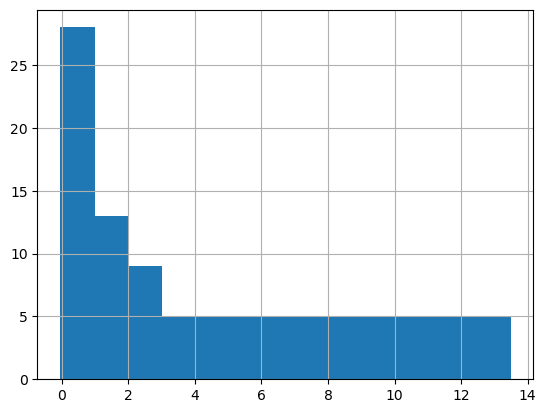

In [21]:
borders = np.linspace(left, right, 5)
borders = [-0.05700837, 1, 2, 3, 4, 13.5]
print(borders)
plt.hist(numbers, bins=borders)
plt.grid()


Доверительные полосы:

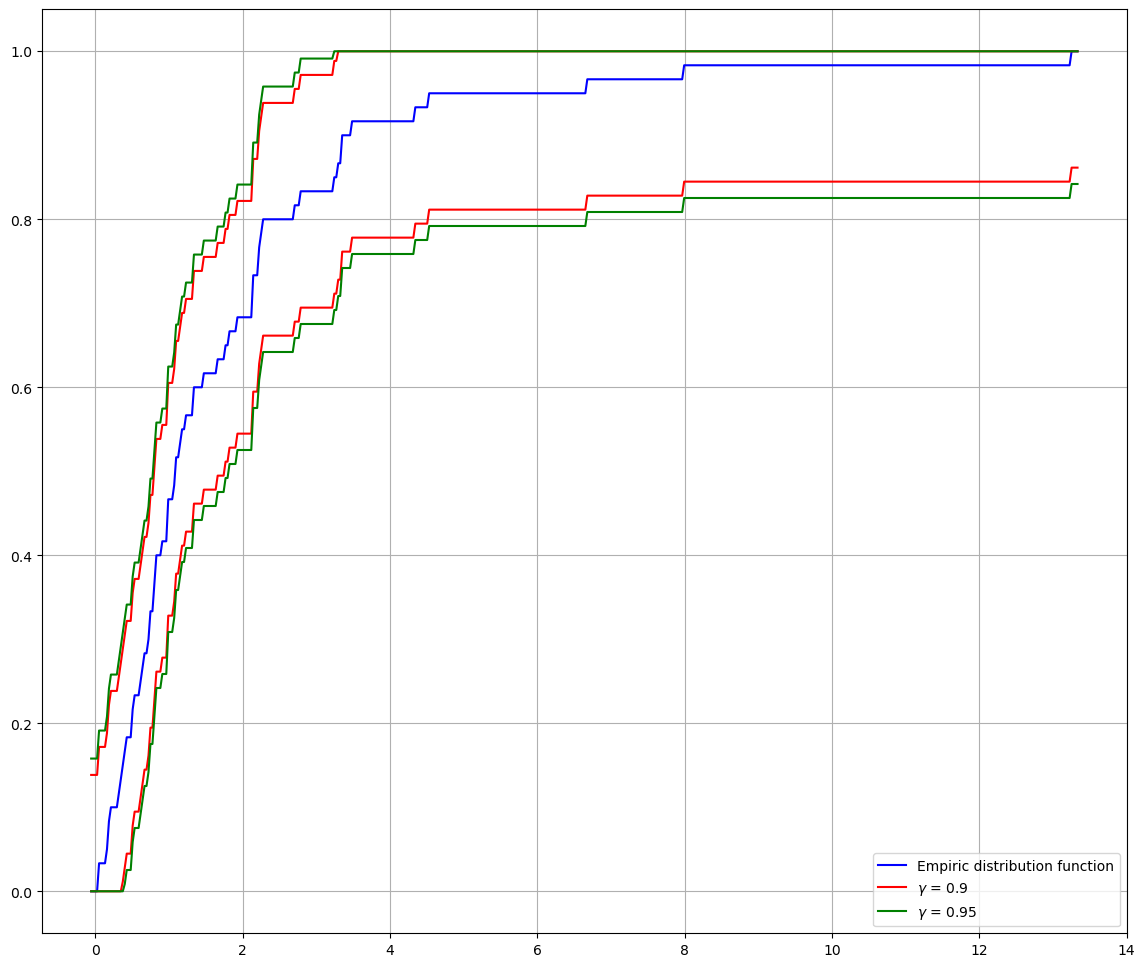

In [22]:
epsilon = lambda gamma: np.sqrt(np.log(1 / (1 - gamma)) / 2 / len(numbers))
L = lambda gamma: np.array([max(F - epsilon(gamma), 0) for F in emp_distr(x)])
R = lambda gamma: np.array([min(F + epsilon(gamma), 1) for F in emp_distr(x)])

f, ax = plt.subplots(1, 1, figsize=(14, 12))

ax.plot(x, emp_distr(x), color='b', label='Empiric distribution function')

for _, vargamma, clr in zip(range(2), [0.9, 0.95], ['r', 'g']):
    ax.plot(x, L(vargamma), color=clr, label=r"$\gamma$" + f" = {vargamma}")
    ax.plot(x, R(vargamma), color=clr)
    
ax.grid()
ax.legend()

Проверка гипотезы на основе хи-квадрат Фишера:

In [23]:
from scipy.stats import expon, gamma
from typing import Union

def theoretic_expon(x: Union[float, np.ndarray], scale):
    return expon.cdf(x, scale=scale)

def theoretic_gamma(x: Union[float, np.ndarray], a, scale):
    # scale = 1 / beta.
    return gamma.cdf(x, a=a, scale=scale)

In [24]:
def chi2_value_big(cdf2check, borders, sigma: float, mu: float, nums, logging: bool = False):
    N = len(nums)
    if logging:
        print(f"borders {borders}")
        print(f"sample size: {N}")
    res = 0
    for i in range(len(borders)-1):
        p_k = cdf2check(borders[i+1], sigma, mu) - cdf2check(borders[i], sigma, mu)
        v_k = len([num for num in nums if borders[i] < num and num < borders[i+1]])
        if logging:
            print(f"curr borders: {borders[i], borders[i+1]}")
            print(f"v_k: {v_k}, p_k: {p_k}")
        try:
            res += (v_k - N*p_k)**2 / (N*p_k)
        except Exception:
            print(f"potential zero = {(N*p_k)}")

    return res

In [39]:
a_mle, _, b_mle = gamma.fit(numbers, floc=0)
print(a_mle, b_mle)

1.0743365437790624 1.6623046408729427


In [10]:
from scipy.optimize import minimize

chi_2 = 6.0
borders = [-0.05700837, 1, 2, 3, 4, 13.5]
theta_gamma = []
print("gamma")
chi2 = lambda x: chi2_value_big(theoretic_gamma, borders, sigma=x[0], mu=x[1], nums=numbers, logging=False)
result = minimize(chi2, np.array([2, 1.5]), method='TNC', tol=1e-15)
print(f"Value: {result['fun']}, min: {result['x']}")
theta_gamma.append(result['x'])
print(result['fun'] < chi_2)


gamma
Value: 0.47810585500676295, min: [1.02717783 1.61637804]
True


In [53]:
def chi2_func(cdf2check, int_num: int, scale: float, nums, logging: bool = False):
    borders = np.linspace(left, right, int_num+1)
    N = len(nums)
    if logging:
        print(f"borders {borders}")
        print(f"sample size: {N}")
    res = 0
    for i in range(int_num):        
        p_k = cdf2check(borders[i+1], scale) - cdf2check(borders[i], scale)
        v_k = len([num for num in nums if borders[i] < num and num < borders[i+1]])
        if logging:
            print(f"curr borders: {borders[i], borders[i+1]}")
            print(f"v_k: {v_k}, p_k: {p_k}")
        try:
            res += (v_k - N*p_k)**2 / (N*p_k)
        except Exception:
            print(f"potential zero = {(N*p_k)}")
    
    return res


In [28]:
from scipy.optimize import minimize

orders = [7, 10, 15]
# N - r - 1,
# N - число интервалов, r - количество параметров, a == 0.05 (уровень значимости)
chi_5 = 11.1
chi_8 = 15.5
chi_13 = 22.4

theta_exp = []
for chi, order in zip([chi_5, chi_8, chi_13], orders):
    chi2 = lambda x: chi2_func(theoretic_expon, order, scale=x[0], nums=numbers, logging=False)
    result = minimize(chi2, np.array([1.5]), method='TNC', tol=1e-15)
    print(f"Value: {result['fun']}, min: {result['x']}")
    theta_exp.append(result['x'])
    print(result['fun'] < chi)


Value: 8.734693670827156, min: [2.22052992]
True
Value: 13.484480326739629, min: [2.44928238]
True
Value: 18.10954170137336, min: [2.53845045]
True


In [15]:
b

[0.0,
 1.4166666666666667,
 2.8333333333333335,
 4.25,
 5.666666666666667,
 7.083333333333334,
 8.5,
 13.232469]

In [14]:
a

0.7093061584368441

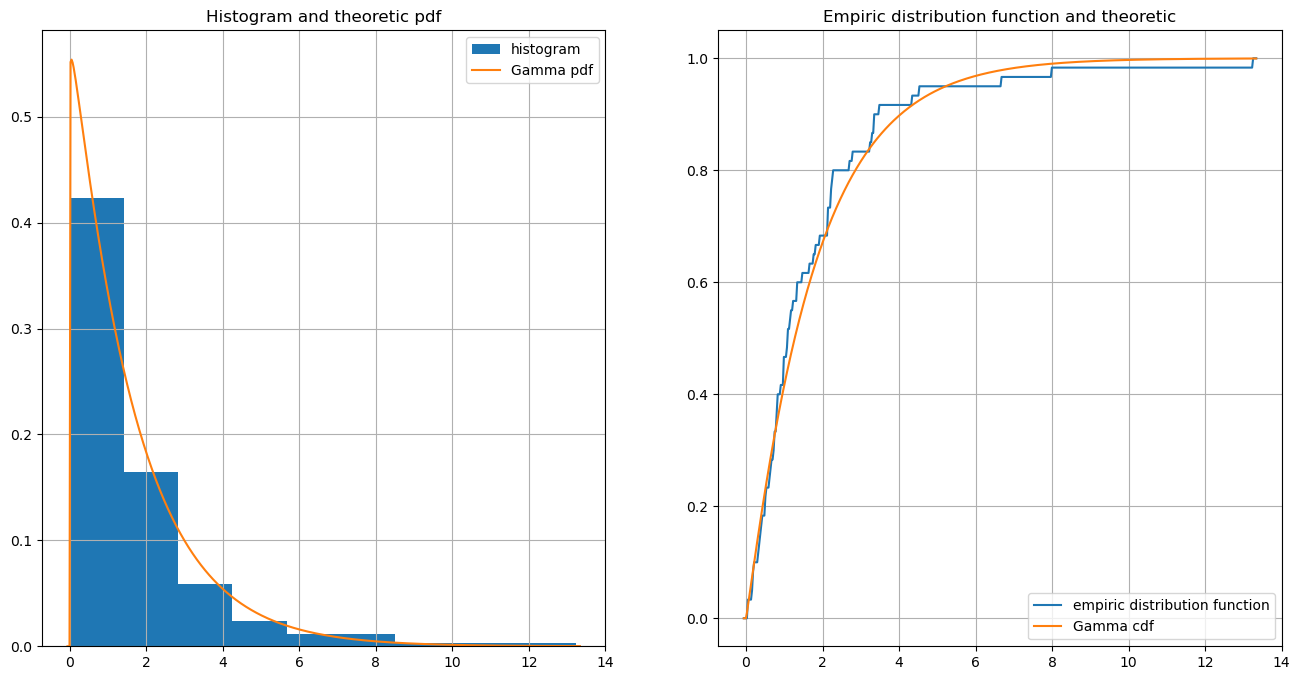

In [40]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))

b = list(np.linspace(0, 8.5, 7))
b.extend([max(numbers)])

ax[0].hist(numbers, density=True, label='histogram', bins=b)
ax[0].plot(x, gamma.pdf(x, a=theta_gamma[0][0], scale=theta_gamma[0][1]), label='Gamma pdf')
ax[0].grid()
ax[0].legend()
ax[0].set_title('Histogram and theoretic pdf')

ax[1].plot(x, emp_distr(x), label='empiric distribution function')
ax[1].grid()
ax[1].set_title('Empiric distribution function and theoretic')
ax[1].plot(x, theoretic_gamma(x, a_mle, b_mle), label='Gamma cdf')
ax[1].legend();

In [11]:
mean, var, skew, kurt = gamma.stats(a=theta_gamma[0][0], scale=theta_gamma[0][1], moments='mvsk')
print(f"{mean}, {var}, {skew}, {kurt}")

1.6603076950622853, 2.6836848970519087, 1.9733638857560365, 5.841247538409246
